In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# При создании модели использовались материалы статьи https://habr.com/ru/post/579050/

In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import cv2
import time
import matplotlib.pyplot as plt
from PIL import Image

from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.ops.boxes import nms

In [ ]:
path_to_files = "/content/drive/MyDrive/Misha/All_data_YOLO/"
os.listdir(path_to_files)
path_to_images = path_to_files + 'images/'
path_to_labels = path_to_files + 'labels/'
path_to_resized_images = path_to_files + 'resized_images/'
try:
    os.mkdir(path_to_files + 'resized_images/')
except OSError as error:
    print('Папка resized_images существует')

In [ ]:
file_names = sorted(os.listdir(path_to_images))
labels_names = sorted(os.listdir(path_to_labels))

In [ ]:
print(file_names)
print(len(file_names))

['00295ab9-54.jpg', '0139bd63-246.jpg', '014248e4-7.jpg', '02a90e41-257.jpg', '05210e0b-93.jpg', '0534d275-215.jpg', '059670bb-277.jpg', '06429140-145.jpg', '06afcc9a-234.jpg', '07550b32-299.jpg', '07bae1d1-122.jpg', '0867df4c-253.jpg', '08bce65b-83.jpg', '0958bb5e-63.jpg', '09957fe1-19.jpg', '0b350902-94.jpg', '0cddd1d0-20.jpg', '0ce03a8b-236.jpg', '0d16e2c3-190.jpg', '0dc15f8a-232.jpg', '0df612aa-34.jpg', '0e545368-126.jpg', '0e896c8a-175.jpg', '0f696bf6-10.jpg', '0fec9f8b-4.jpg', '0ffdf60d-65.jpg', '111f3126-7.jpg', '11425f6c-252.jpg', '1160806d-99.jpg', '11933abf-154.jpg', '119e9857-219.jpg', '1240dcd3-102.jpg', '133cd500-148.jpg', '1432e69c-245.jpg', '14ce23d5-33.jpg', '1569265e-32.jpg', '15764358-78.jpg', '16129960-177.jpg', '16215539-57.jpg', '16d291f9-49.jpg', '1704aead-53.jpg', '18370751-226.jpg', '18dc6175-113.jpg', '19949439-96.jpg', '199527d5-268.jpg', '19f6895e-98.jpg', '1a7649b8-224.jpg', '1abcbc6f-76.jpg', '1b3c43eb-109.jpg', '1b541220-282.jpg', '1ef2a50a-130.jpg', '1f20

In [ ]:
print(labels_names)
print(len(labels_names))

['00295ab9-54.txt', '0139bd63-246.txt', '014248e4-7.txt', '02a90e41-257.txt', '05210e0b-93.txt', '0534d275-215.txt', '059670bb-277.txt', '06429140-145.txt', '06afcc9a-234.txt', '07550b32-299.txt', '07bae1d1-122.txt', '0867df4c-253.txt', '08bce65b-83.txt', '0958bb5e-63.txt', '09957fe1-19.txt', '0b350902-94.txt', '0cddd1d0-20.txt', '0ce03a8b-236.txt', '0d16e2c3-190.txt', '0dc15f8a-232.txt', '0df612aa-34.txt', '0e545368-126.txt', '0e896c8a-175.txt', '0f696bf6-10.txt', '0fec9f8b-4.txt', '0ffdf60d-65.txt', '111f3126-7.txt', '11425f6c-252.txt', '1160806d-99.txt', '11933abf-154.txt', '119e9857-219.txt', '1240dcd3-102.txt', '133cd500-148.txt', '1432e69c-245.txt', '14ce23d5-33.txt', '1569265e-32.txt', '15764358-78.txt', '16129960-177.txt', '16215539-57.txt', '16d291f9-49.txt', '1704aead-53.txt', '18370751-226.txt', '18dc6175-113.txt', '19949439-96.txt', '199527d5-268.txt', '19f6895e-98.txt', '1a7649b8-224.txt', '1abcbc6f-76.txt', '1b3c43eb-109.txt', '1b541220-282.txt', '1ef2a50a-130.txt', '1f20

In [ ]:
# Функция для изменения размеров изображения
def scale_image(input_image_path,
                output_image_path,
                width=None,
                height=None
                ):
    original_image = Image.open(input_image_path)
    w, h = original_image.size
    #print('The original image size is {wide} wide x {height} '
    #      'high'.format(wide=w, height=h))
 
    if width and height:
        max_size = (width, height)
    elif width:
        max_size = (width, h)
    elif height:
        max_size = (w, height)
    else:
        # No width or height specified
        raise RuntimeError('Width or height required!')
 
    original_image.thumbnail(max_size, Image.ANTIALIAS)
    original_image.save(output_image_path)
 
    scaled_image = Image.open(output_image_path)
    width, height = scaled_image.size
    #print('The scaled image size is {wide} wide x {height} '
    #      'high'.format(wide=width, height=height))
    return width, height
 
 
#if __name__ == '__main__':
#    scale_image(input_image_path=path_to_images+'00295ab9-54.jpg',
#                output_image_path=path_to_resized_images+'00295ab9-54.jpg',
#                width=320)

In [ ]:
# Преобразование фото и bounding box'es к измененным размерам фото
total_label_coords = []
total_classes_list = []
for label_item in labels_names:
    label_coords = []
    classes_list = []
    width, height = scale_image(path_to_images+label_item[:-3]+'jpg', 
                                path_to_resized_images+label_item[:-3]+'jpg',
                                width=480)
    with open(path_to_labels+label_item, 'r') as f:
        data = f.read()
    for item in data.split('\n'):
        if len(item)!=0:
            list_coords = [float(x) for x in item.split()[1:]]
            x_min = int(width*list_coords[0] - width*list_coords[2]/2)
            y_min = int(height*list_coords[1] - height*list_coords[3]/2)
            x_max = int(width*list_coords[0] + width*list_coords[2]/2)
            y_max = int(height*list_coords[1] + height*list_coords[3]/2)
            if (y_min==y_max) or (x_min == x_max):
                print(item, label_item)
            label_coords.append([x_min, y_min, x_max, y_max])
            classes_list.append(1)
    total_label_coords.append(label_coords)
    total_classes_list.append(classes_list)
print(len(total_label_coords))

400


In [ ]:
# Converting lists of tuples into 
# pandas Dataframe. 
list_tuples = list(zip(file_names, total_classes_list, total_label_coords)) 
d_frame = pd.DataFrame(list_tuples, columns=['filename', 'class', 'bbox'])
d_frame.to_csv(path_to_files+'data.csv')

In [ ]:
d_frame.sample(5)

filename                                              class  \
76   2e49eb33-205.jpg  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
86   319335ce-150.jpg  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
21   0e545368-126.jpg  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
104   3a875ef0-11.jpg  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
271  a64777d8-231.jpg  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                                  bbox  
76   [[36, 2, 47, 9], [0, 6, 5, 14], [10, 12, 17, 2...  
86   [[34, 9, 43, 20], [59, 9, 69, 15], [80, 14, 87...  
21   [[19, 11, 27, 19], [30, 27, 38, 35], [0, 32, 7...  
104  [[141, 88, 148, 97], [183, 96, 191, 101], [256...  
271  [[80, 10, 87, 18], [118, 30, 125, 39], [149, 5...

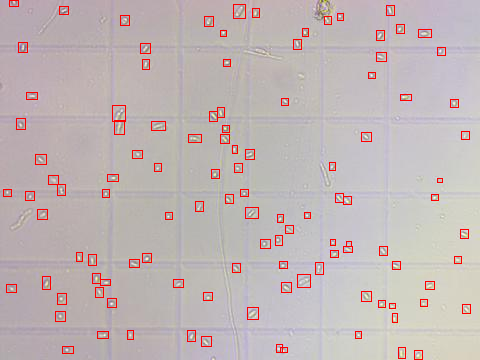

In [ ]:
# Функция для просмотра размеченных изображений
def draw_img_with_box(df_index, df_train, path_to_images=path_to_resized_images):  
    path_to_img = os.path.join(path_to_images, df_train.loc[df_index, 'filename'])
    img = cv2.imread(path_to_img)
    #width, height = img.size
    width = int(img.shape[1])
    height = int(img.shape[0])
    boxes =  df_train.loc[df_index, 'bbox']
    for box in boxes:
        cv2.rectangle(img, 
            (int(box[0]), int(box[1])), 
            (int(box[2]), int(box[3])), 
            (0, 0, 255), 0)
    cv2_imshow(img)
    
draw_img_with_box(50, d_frame)

In [ ]:
class MyDataset(Dataset):
  
    def __init__(self, dataframe, img_path):
        
        self.df = dataframe
        self.img_path = img_path

    def __len__(self):
        return self.df.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df.loc[index,'filename']
        boxes = torch.Tensor(self.df.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df.loc[index, 'class']).to(torch.int64)
        #area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        #iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        return img, target

In [ ]:
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# деление на трейн и тест
rnd_seed = 123
from sklearn.model_selection import train_test_split 
df_train, df_val = train_test_split(d_frame, test_size=0.2, random_state=rnd_seed)
df_train = df_train.reset_index().drop('index', axis=1)
df_val = df_val.reset_index().drop('index', axis=1)
print(f'Количество строк в тренировочной выборке: {len(df_train)}')
print(f'Количество строк в тестовой выборке: {len(df_val)}')

Количество строк в тренировочной выборке: 320
Количество строк в тестовой выборке: 80


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=2, pretrained=False).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_dataset = MyDataset(df_train, '/content/drive/MyDrive/Misha/All_data_YOLO/resized_images')
val_dataset = MyDataset(df_val, '/content/drive/MyDrive/Misha/All_data_YOLO/resized_images')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=False,
    collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def train(train_dataloader): 
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [ ]:
train_losses = []
val_losses = []
try:
    for epoch in range(20):
        start = time.time()
        train_loss = train(train_data_loader)
        val_loss = val(val_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


	Итерация #0 loss: 2.186030864715576
	Итерация #50 loss: 1.223940372467041
	Итерация #100 loss: 0.8650974631309509
Эпоха #0 train_loss: 0.4428499810397625, val_loss: 0.3523809604346752
Потрачено 4.5 минут на 0 эпоху
	Итерация #0 loss: 0.9820173978805542
	Итерация #50 loss: 0.950455904006958
	Итерация #100 loss: 0.923211395740509
Эпоха #1 train_loss: 0.32604275513440373, val_loss: 0.3149945750832558
Потрачено 4.6 минут на 1 эпоху
	Итерация #0 loss: 0.9475289583206177
	Итерация #50 loss: 0.903388500213623
	Итерация #100 loss: 0.8393627405166626
Эпоха #2 train_loss: 0.29492973890155555, val_loss: 0.2874206803739071
Потрачено 4.5 минут на 2 эпоху
	Итерация #0 loss: 0.7125762104988098
	Итерация #50 loss: 0.895946204662323
	Итерация #100 loss: 0.7042137384414673
Эпоха #3 train_loss: 0.2908275701105595, val_loss: 0.29327304363250734
Потрачено 4.5 минут на 3 эпоху
	Итерация #0 loss: 0.9250597953796387
	Итерация #50 loss: 0.9758262634277344
	Итерация #100 loss: 0.8237587213516235
Эпоха #4 train

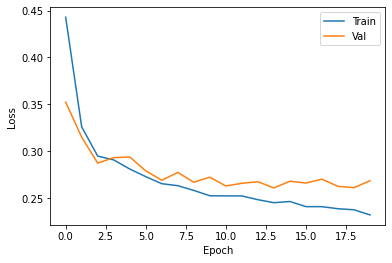

In [ ]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

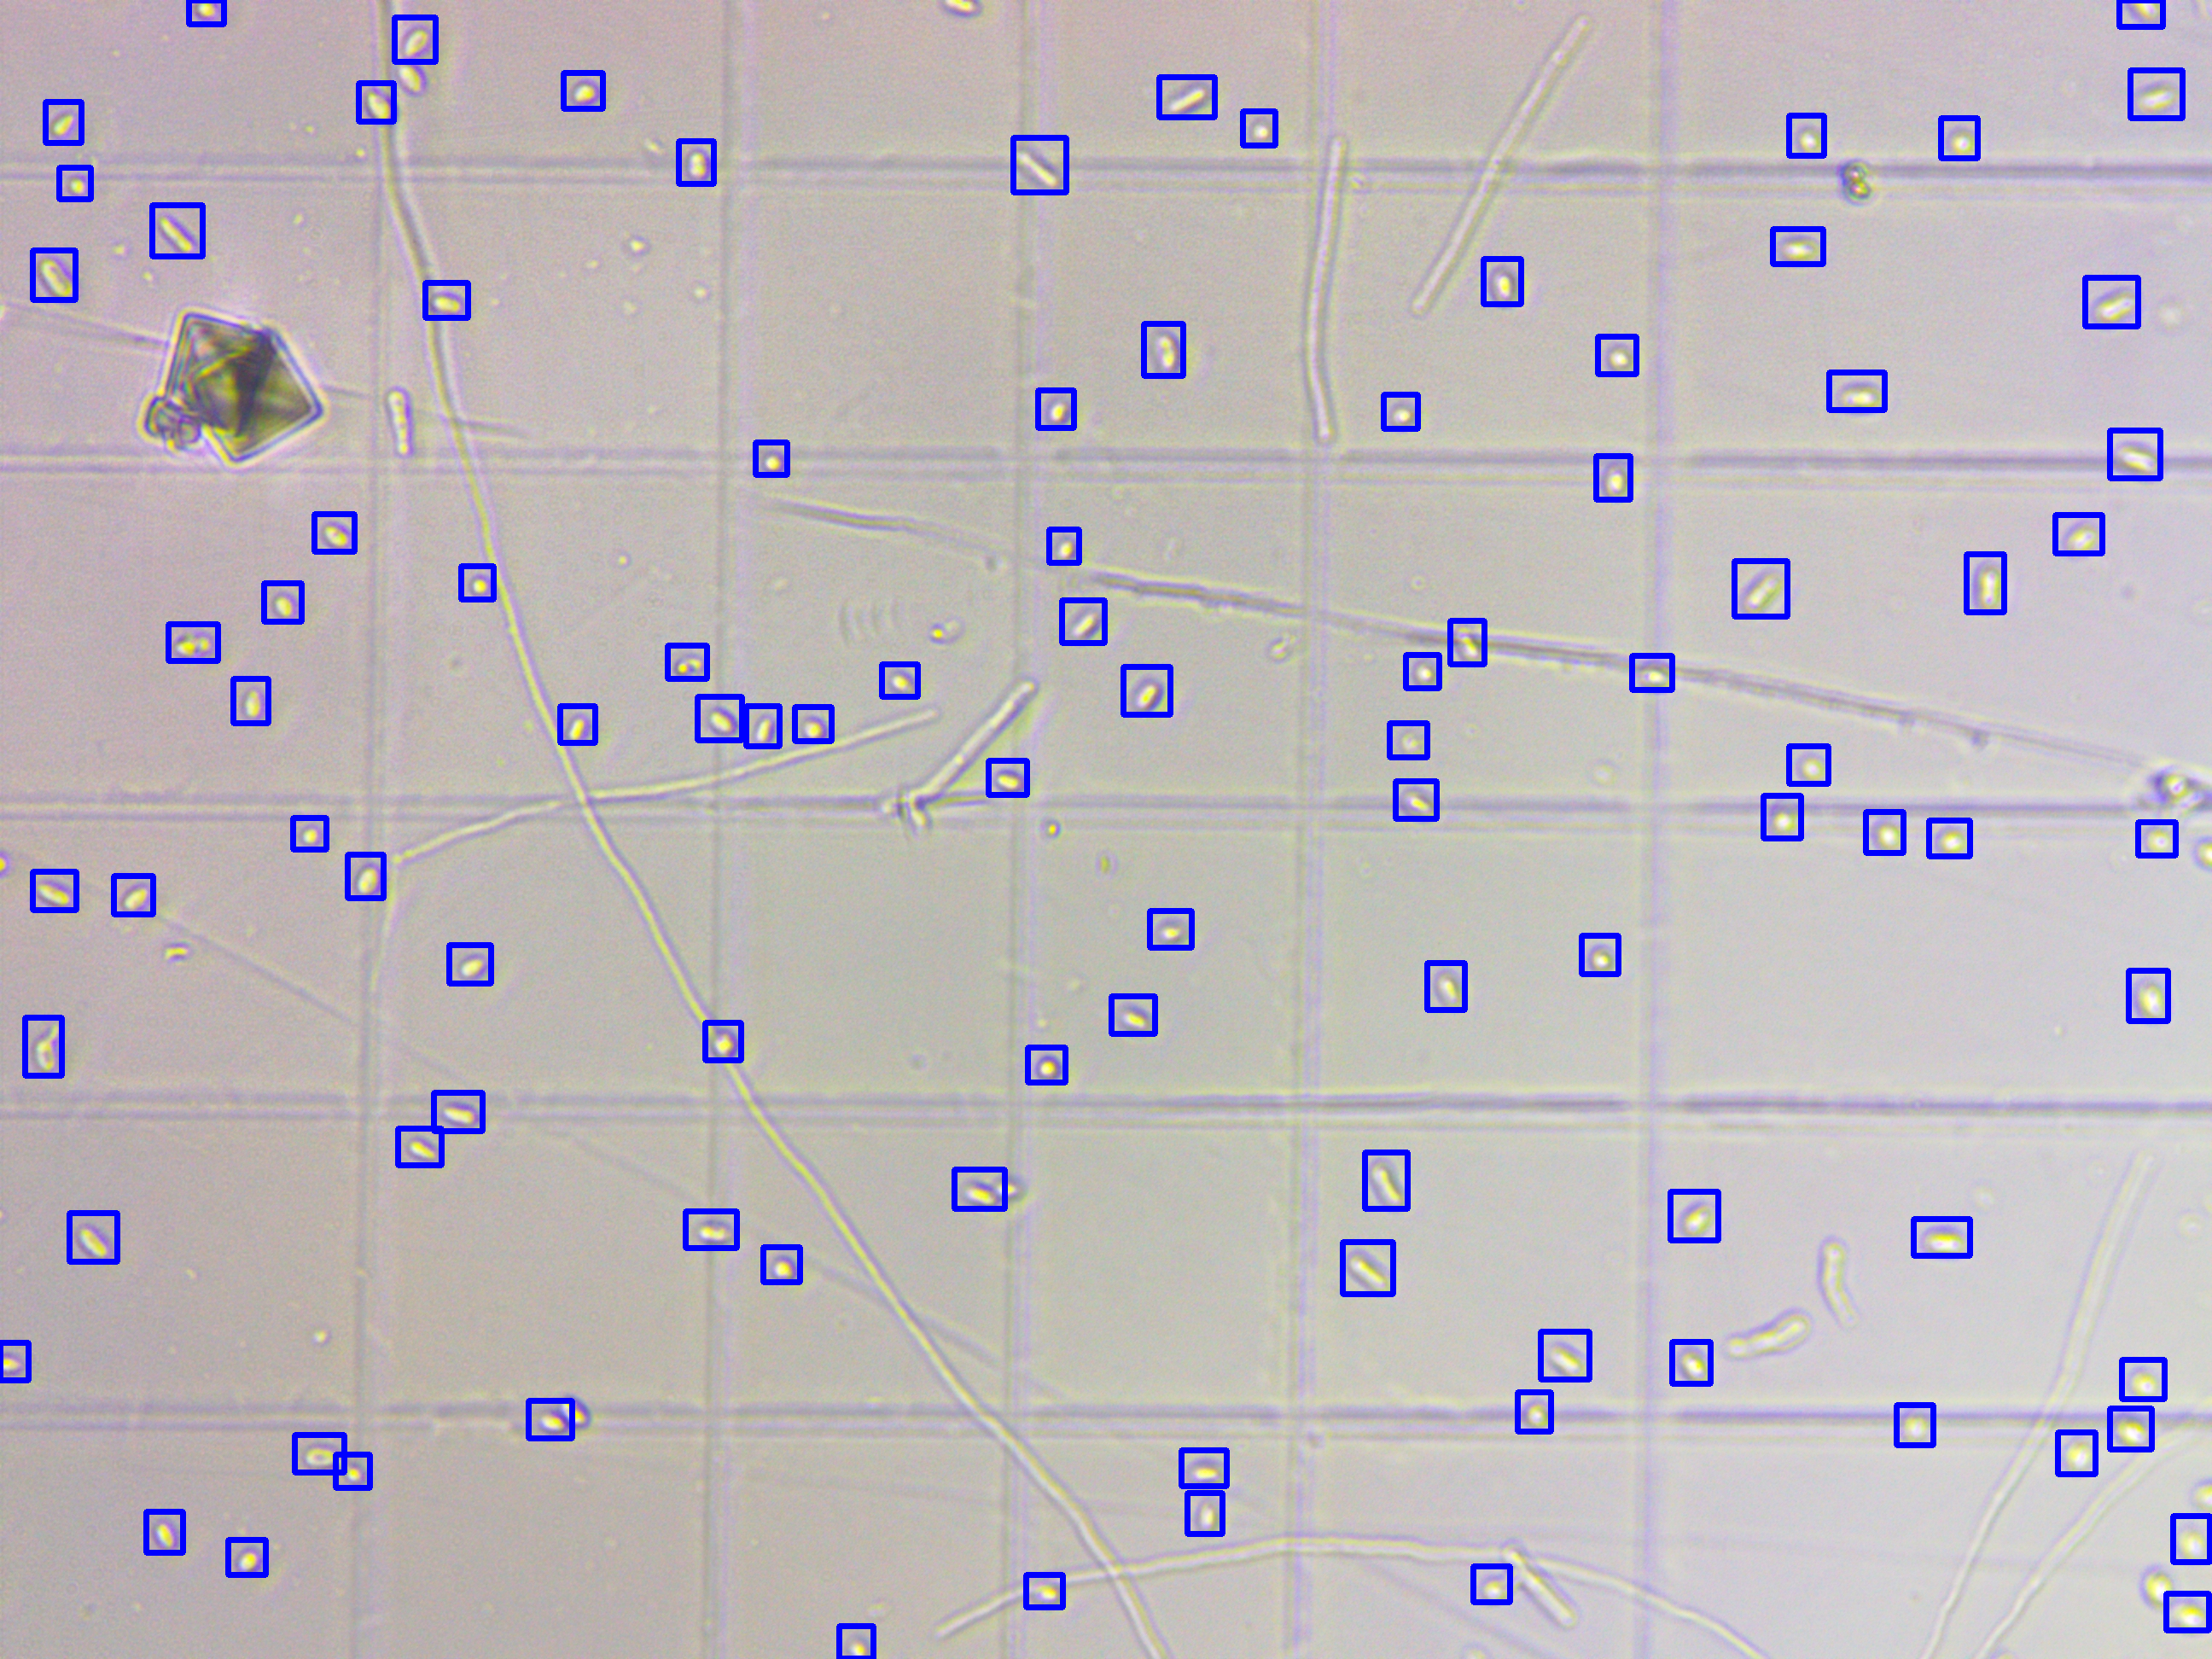

In [ ]:
### Посмотрим, на сколько хорошо обучилась модель. Применим алгоритм non-maximum suppression, 
### который реализован в библиотеке torchvision. Он объединяет похожие рамки на основе их 
### взаимного пересечения. 
def draw_predict(df_index, iou_threshold=0.1, threshold=0.7, scale_percent=25):
    model.eval()
    img = cv2.imread(os.path.join(path_to_images, df_train.loc[df_index, 'filename']))
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            cv2.rectangle(img, 
                    (int(box[0]), int(box[1])), 
                    (int(box[2]), int(box[3])), 
                    (255, 0, 0), 5)
    #width = int(img.shape[1])
    #height = int(img.shape[0])
    #dim = (width, height)   
    #img = cv2.resize(img, dim)
    cv2_imshow(img)
draw_predict(63, 0.1)

In [ ]:
# Сохраняем веса модели
torch.save(model.state_dict(), path_to_files+'fasterrcnn_resnet50_fpn.pth')

In [ ]:
# Для последующего доступа к модели необходимо выполнить следующие команды:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = create_model(2).to(device)
model.load_state_dict(torch.load(path_to_files+'fasterrcnn_resnet50_fpn.pth'))

## Архив

In [ ]:
def draw_img_with_box(df_index, scale_percent=20, path_to_img=path_to_img):
    img = cv2.imread(path_to_img)
    boxes =  df_train.loc[df_index, 'bbox']
    for box in boxes:
        cv2.rectangle(img, 
            (int(box[0]), int(box[1])), 
            (int(box[2]), int(box[3])), 
            (255, 0, 0), 5)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)   
    img = cv2.resize(img, dim)
    cv2_imshow(img)

draw_img_with_box(100)

In [ ]:
# Отображение картинки в уменьшенном виде
scale_percent = 100
img = cv2.imread(path_to_img+'00295ab9-54.jpg')
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)   
img = cv2.resize(img, dim)
cv2_imshow(img)
print(width, height)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img_rgb)

518 388


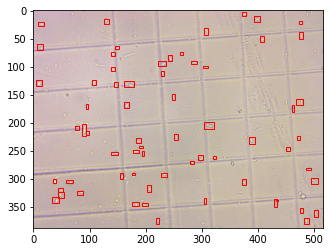

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

with open(path_to_labels+'00295ab9-54.txt', 'r') as f:
    data = f.read()

scaling_img = 0.2
with Image.open(path_to_images+'00295ab9-54.jpg') as image:
    width, height = image.size
    image = image.resize((int(width*scaling_img), int(height*scaling_img)))
    #image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    width, height = image.size
print(width, height)
plt.imshow(image)

"""
X_CENTER_NORM = X_CENTER_ABS/IMAGE_WIDTH  
Y_CENTER_NORM = Y_CENTER_ABS/IMAGE_HEIGHT  
WIDTH_NORM = WIDTH_OF_LABEL_ABS/IMAGE_WIDTH  
HEIGHT_NORM = HEIGHT_OF_LABEL_ABS/IMAGE_HEIGHT  
"""

for item in data.split('\n'):
    if len(item)!=0:
        list_coords = [float(x) for x in item.split()[1:]]
        x_left_down = int(width*list_coords[0] - width*list_coords[2]/2)
        y_left_down = int(height*list_coords[1] - height*list_coords[3]/2)
        width_img = int(width*list_coords[2])
        height_img = int(height*list_coords[3])
        ax = plt.gca()
    
        rect = patches.Rectangle((x_left_down,y_left_down), 
                                 width_img, 
                                 height_img, 
                                 linewidth=1, 
                                 edgecolor='red', 
                                 fill = False)

        ax.add_patch(rect)

plt.show()